Started on 24 June 2019

# Introduction

In [1]:
import numpy as np
import pandas as pd
import os
print(os.listdir("input"))

['sample_submission.csv', 'test', 'train', 'train_labels.csv']


# Examine the data

In [2]:
# load data from csv files
train_df = pd.read_csv('input/train_labels.csv')
test_df = pd.read_csv('input/sample_submission.csv')
print(train_df.shape, test_df.shape)

(220025, 2) (57458, 2)


In [3]:
train_df['id'] = train_df['id'].apply(lambda x: x+'.tif')
test_df['id'] = test_df['id'].apply(lambda x: x+'.tif')

In [4]:
train_df['label'] = train_df['label'].astype(str)

In [5]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [6]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

train_path = 'input/train/'
test_path = 'input/test/'

#### Here are some images from the training data that are labelled as positive, i.e. '1':

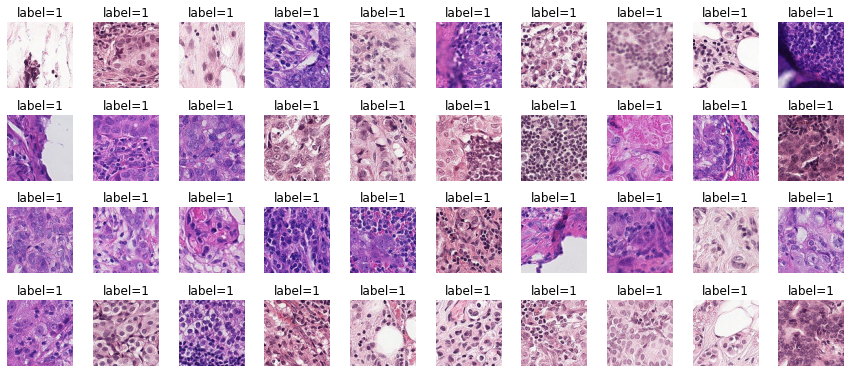

In [7]:
# look at some of the pics from train_df labelled '1'
positive = train_df[train_df['label']=='1']
plt.figure(figsize=(15,7))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(load_img(train_path+positive.iloc[i]['id']))
    plt.title("label=%s" % positive.iloc[i]['label'], y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

#### Here are some images from the training data that are labelled negative, i.e. '0':

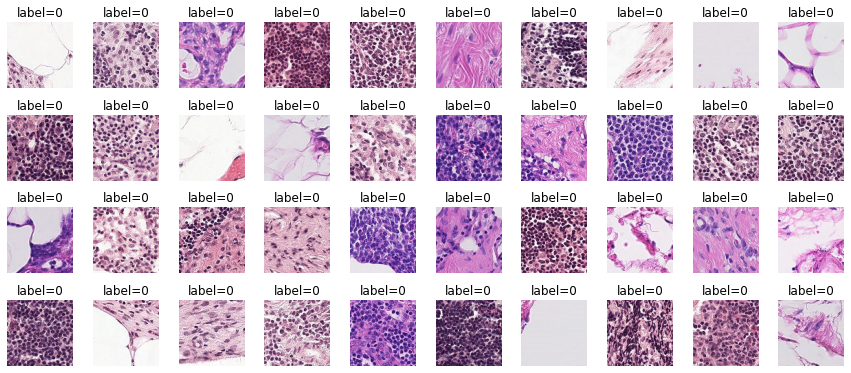

In [16]:
# look at some of the pics from train_df labelled '0'
negative = train_df[train_df['label']=='0']
plt.figure(figsize=(15,7))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(load_img(train_path+negative.iloc[i]['id']))
    plt.title("label=%s" % negative.iloc[i]['label'], y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

# Setting up ImageDataGenerator

In [28]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [29]:
# set up two data generators; (1) training, (2) validation from train set
n_x = 96
train_generator = datagen.flow_from_dataframe(dataframe=train_df, 
                                              directory=train_path, 
                                              target_size=(n_x,n_x), 
                                              x_col='id', y_col='label', 
                                              subset='training', 
                                              batch_size=128, seed=12, 
                                              class_mode='categorical')

Found 176020 validated image filenames belonging to 2 classes.


In [30]:
valid_generator = datagen.flow_from_dataframe(dataframe=train_df, 
                                              directory=train_path,
                                              target_size=(n_x,n_x), 
                                              x_col='id', y_col='label', 
                                              subset='validation', 
                                              batch_size=128, seed=12, 
                                              class_mode='categorical')

Found 44005 validated image filenames belonging to 2 classes.


In [31]:
# set up data generator for test set
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                                  directory=test_path, 
                                                  target_size=(n_x,n_x), 
                                                  x_col='id', y_col=None, 
                                                  batch_size=1, seed=12, 
                                                  shuffle=False, 
                                                  class_mode=None)

Found 57458 validated image filenames.


In [32]:
# define step sizes for model training
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size
print(step_size_train, step_size_valid, step_size_test)

1375 343 57458


# Create CNN Model

In [33]:
# build the CNN from keras
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=5, activation='relu', input_shape=(96, 96, 3)))
model.add(layers.Conv2D(32, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
model.add(layers.Dropout(rate=0.4))
model.add(layers.Conv2D(64, kernel_size=5, activation='relu'))
model.add(layers.Conv2D(64, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
model.add(layers.Dropout(rate=0.4))
model.add(layers.Conv2D(128, kernel_size=5, activation='relu'))
model.add(layers.Conv2D(128, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
model.add(layers.Dropout(rate=0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 92, 92, 32)        2432      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 88, 88, 32)        25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 40, 40, 64)        51264     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 36, 36, 64)        102464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 64)       

In [34]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])

#### Run the model on the train and validation data, and capture metrics history to visualise the performance of the model

In [35]:
# Train and validate the model
epochs = 5
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=step_size_train, 
                              validation_data=valid_generator, 
                              validation_steps=step_size_valid,
                              epochs=epochs)

Epoch 1/5


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1375/1375 [==============================] - 3419s 2s/step - loss: 0.5451 - accuracy: 0.7231 - val_loss: 0.4177 - val_accuracy: 0.8139
Epoch 2/5
1375/1375 [==============================] - 3352s 2s/step - loss: 0.4266 - accuracy: 0.8084 - val_loss: 0.3843 - val_accuracy: 0.8316
Epoch 3/5
1375/1375 [==============================] - 3273s 2s/step - loss: 0.3821 - accuracy: 0.8325 - val_loss: 0.3429 - val_accuracy: 0.8522
Epoch 4/5
1375/1375 [==============================] - 3233s 2s/step - loss: 0.3516 - accuracy: 0.8474 - val_loss: 0.3248 - val_accuracy: 0.8647
Epoch 5/5
1375/1375 [==============================] - 3307s 2s/step - loss: 0.3310 - accuracy: 0.8597 - val_loss: 0.3102 - val_accuracy: 0.8578


In [53]:
with open('trainHistoryOld', 'wb') as handle: # saving the history of the model
    pickle.dump(history.history, handle)

In [43]:
import pickle

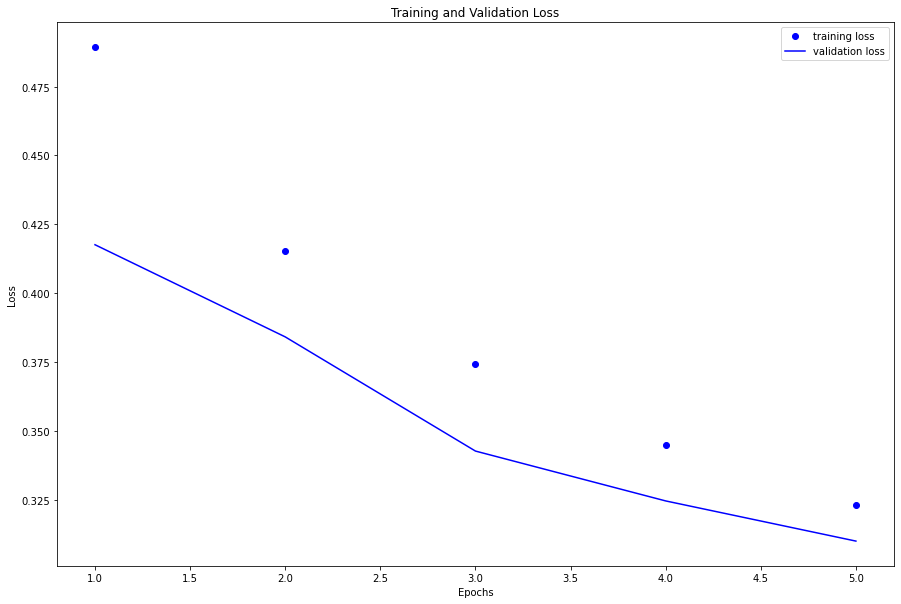

In [46]:
# plot and visualise the training and validation losses
loss = history.history['loss']
dev_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, dev_loss, 'b', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

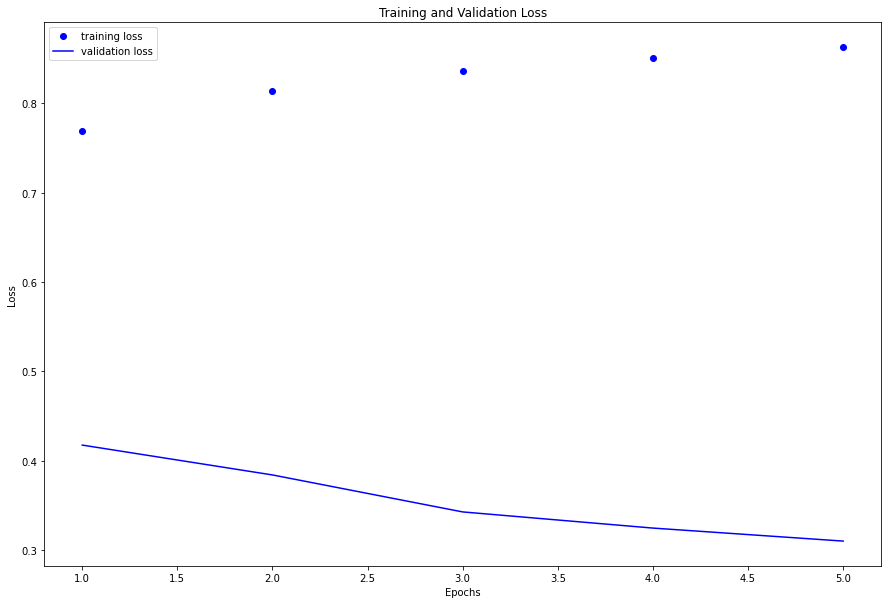

In [56]:
# plot and visualise the training and validation losses
loss = history.history['accuracy']
dev_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, dev_loss, 'b', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions

In [47]:
# predict on test set
test_generator.reset()
pred = model.predict_generator(test_generator, steps=step_size_test, 
                               verbose=1)

   12/57458 [..............................] - ETA: 4:36   

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


57458/57458 [==============================] - 247s 4ms/step


In [50]:
# generate submission file in csv format
sub.to_csv('submission.csv', index=False)

In [ ]:
abc = model.evaluate(test_generator, steps=step_size_test, 
                               verbose=1)

1375/1375 [==============================] - 3419s 2s/step - loss: 0.5451 - accuracy:0.8243